# Features
+ Training with pytorch lightning and a 8 core tpu
+ Multi-label stratification split
+ Resnet50 with focal loss and rgby channels
+ Use jpg images to speed up training speed 

## Install Deps

In [1]:
!pip install iterative-stratification
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version 1.7 --apt-packages libomp5 libopenblas-dev
!pip install -U pytorch-lightning==1.1.4 albumentations

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5116  100  5116    0     0  39353      0 --:--:-- --:--:-- --:--:-- 39658
Updating... This may take around 2 minutes.
Updating TPU runtime to pytorch-1.7 ...
Found existing installation: torch 1.7.0
Uninstalling torch-1.7.0:
Done updating TPU runtime
  Successfully uninstalled torch-1.7.0
Found existing installation: torchvision 0.8.1
Uninstalling torchvision-0.8.1:
  Successfully uninstalled torchvision-0.8.1
Copying gs://tpu-pytorch/wheels/torch-1.7-cp37-cp37m-linux_x86_64.whl...

Operation completed over 1 objects/114.2 MiB.                                    
Copying gs://tpu-pytorch/wheels/torch_xla-1.7-cp37-cp37m-linux_x86_64.whl...

Operation completed over 1 objects/127.4 MiB.                                    
Copying gs://tpu-pytorch/wheels/torchvision-1.7-cp37-cp37m-linux_x86_64.whl...

Operation completed over 1 

## Import packages

In [2]:
import pandas as pd
from PIL import Image
import os
import numpy as np
from io import BytesIO

from matplotlib import pyplot as plt

from tqdm.notebook import tqdm
import traceback

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import models

import cv2

from pytorch_lightning import LightningModule, Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.profiler import AdvancedProfiler
from pytorch_lightning.loggers import TensorBoardLogger
import time
import sys

## Hyper params

In [3]:
img_w, img_h = 512, 512
n_classes = 19


batch_size = 8
epoch = 1
lr = 3e-4

## Image Loading Pipeline

In [4]:
df = pd.read_csv('../input/hpa-single-cell-image-classification/train.csv')
df

,ID,Label
0,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0,8|5|0
1,5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0,14|0
2,60b57878-bb99-11e8-b2b9-ac1f6b6435d0,6|1
3,5c1a898e-bb99-11e8-b2b9-ac1f6b6435d0,16|10
4,5b931256-bb99-11e8-b2b9-ac1f6b6435d0,14|0
...,...,...
21801,dd0989c4-bbca-11e8-b2bc-ac1f6b6435d0,14
21802,dd1f7fb8-bbca-11e8-b2bc-ac1f6b6435d0,3|0
21803,dd5cb36a-bbca-11e8-b2bc-ac1f6b6435d0,14|0
21804,df573730-bbca-11e8-b2bc-ac1f6b6435d0,14


In [5]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

from torchvision import transforms

aug_train = A.Compose([
    A.Resize(img_h, img_w, interpolation=cv2.INTER_LINEAR),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(),
    A.Normalize(mean=(0.5, 0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5, 0.5)),
    ToTensorV2(transpose_mask=True)
])


aug_val = A.Compose([
    A.Resize(img_h, img_w, interpolation=cv2.INTER_LINEAR),
    A.Normalize(mean=(0.5, 0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5, 0.5)),
    ToTensorV2(transpose_mask=True)
])

class MyDataset(Dataset):
    def __init__(self, df, aug):
        self.imgs = df['ID'].values
        self.labels = df['Label'].values
        self.aug = aug
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img = cv2.imread(f'../input/hpa-image-loading-speed-up-for-training/train/{self.imgs[idx]}_rgb.jpg', cv2.IMREAD_UNCHANGED)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgy = cv2.imread(f'../input/hpa-image-loading-speed-up-for-training/train/{self.imgs[idx]}_yellow.jpg', cv2.IMREAD_UNCHANGED)
        
        img = np.concatenate((img, imgy.reshape((imgy.shape[0], imgy.shape[1], 1))), axis=2)
        
        aug_rst = self.aug(image=img)
        img = aug_rst['image']
        
        label = torch.zeros(n_classes, dtype=torch.long)
        
        for x in self.labels[idx].split('|'):
            x = int(x)
            
            label[x] = 1
        
        return img, label


def reverse_transform(a):
    r = a[0].numpy()
    g = a[1].numpy()
    b = a[2].numpy()
    y = a[3].numpy()
    
    return (np.dstack([r * 0.5 + 0.5, g * 0.5 + 0.5, b * 0.5 + 0.5]) * 255).astype(np.uint8)

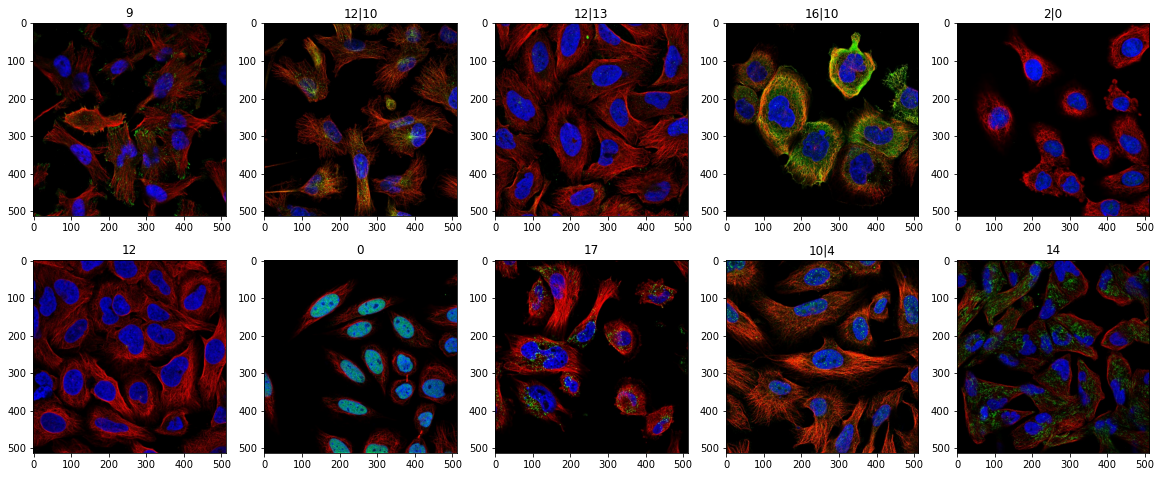

In [6]:
import random

ds = MyDataset(df, aug_train)

plt.figure(figsize=(20, 8))
for i in range(10):
    idx = random.randrange(0, len(ds))
    d = ds[idx]
    
    plt.subplot(2, 5, i + 1)
    plt.imshow(reverse_transform(d[0]))
    plt.title(df.iloc[idx].Label)

## Define Model

In [7]:
sys.path.append('../input/pretrainedmodels')
import pretrainedmodels

!mkdir -p /root/.cache/torch/hub/checkpoints/
!ln -s /kaggle/input/pretrained-model-weights-pytorch/* /root/.cache/torch/hub/checkpoints/

In [8]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        
        self.gamma = gamma
        
        self.bce = nn.BCEWithLogitsLoss(reduction='none')
        
    def forward(self, logits, targets):
        logpt = self.bce(logits, targets)
        
        pt = torch.exp(-logpt)
        
        loss = ((1 - pt) ** self.gamma) * logpt
        
        return loss.mean()


class Model(LightningModule):
    def __init__(self, lr, batch_size, steps_per_epoch, n_epoch):
        super().__init__()
        
        self.save_hyperparameters()
        self.lr = lr
        
        self.model = pretrainedmodels.resnet50(pretrained='imagenet')
        
        stem = nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        w = self.model.conv1.weight
        stem.weight = nn.Parameter(torch.cat((w, 0.5*(w[:,:1,:,:]+w[:,2:,:,:])),dim=1))
        self.model.conv1 = stem

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, n_classes)
        
        self.crit = FocalLoss()

        
    def forward(self, ipt):
        x = self.model.features(ipt)
        x = self.avg_pool(x)
        x = self.fc(x.view(-1, 2048))
        return x
    
    def training_step(self, batch, batch_idx):
        self.train()
        x, y = batch
        
        pred = self(x)
        
        loss = self.crit(pred, y.float())

        rst = (pred > 0.5).long()
        acc = (rst == y).float().mean()
        
        self.log('train_loss', loss)
        self.log('train_acc', acc)
        
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=1e-4)
        scheduler = {
            'scheduler': torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=self.lr, 
                                                             total_steps=self.hparams.n_epoch * self.hparams.steps_per_epoch,
                                                             anneal_strategy='cos',
                                                             cycle_momentum=False,
                                                             pct_start=0.1,
                                                            ),
            'interval': 'step',
            'frequency': 1
        }
        
        return [optimizer], [scheduler]
    
    
    def validation_step(self, batch, batch_idx):
        with torch.no_grad():
            self.eval()
            x, y = batch
            
            pred = self(x)
        
            loss = self.crit(pred, y.float())

            rst = (pred > 0.5).long()
            acc = (rst == y).float().mean()
            
            self.log('val_loss', loss)
            self.log('val_acc', acc)

def init_seed(worker_id):
    random.seed(torch.torch.initial_seed())

## Calc Label for MultilabelStratifiedKFold

In [9]:
Y = []

for row in tqdm(df.itertuples()):
    y = np.zeros(n_classes, dtype=np.int64)
    
    for _id in row.Label.split('|'):
        y[int(_id)] = 1
        
    Y.append(y)
    
Y = np.stack(Y)
Y

|          | 0/? [00:00<?, ?it/s]

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

## Start Training

In [10]:
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold


skf = MultilabelStratifiedKFold(n_splits=5, random_state=42, shuffle=True)

for fold_idx, (train, val) in enumerate(skf.split(df, Y)):
    print('training fold', fold_idx)
    df_train = df.loc[train].sort_index()
    df_val = df.loc[val].sort_index()

    ds_train = MyDataset(df_train, aug_train)

    print('train samples:', len(df_train))
    train_loader = DataLoader(ds_train, batch_size=batch_size, num_workers=0, shuffle=True,
                              worker_init_fn=init_seed, drop_last=True)

    ds_val = MyDataset(df_val, aug_val)
    val_loader = DataLoader(ds_val, batch_size=batch_size, num_workers=0, drop_last=True)

    checkpoint_callback = ModelCheckpoint(
        save_top_k=1,
        save_last=True,
        verbose=True,
        monitor='val_acc',
        mode='max',
        prefix=''
    )

    logger = TensorBoardLogger(save_dir='.', version=f'fold_{fold_idx}', name='lightning_logs')

    trainer = Trainer(logger=logger,
                      tpu_cores=8,
                      callbacks=[LearningRateMonitor(), checkpoint_callback],
                      flush_logs_every_n_steps=100,
                      log_every_n_steps=100,
                      max_epochs=epoch,
                      benchmark=True,
                      precision=16)

    model = Model(lr, batch_size, len(train_loader), epoch)
    trainer.fit(model, train_dataloader=train_loader, val_dataloaders=val_loader)

    break

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
GPU available: False, used: False
TPU available: True, using: 8 TPU cores
Using native 16bit precision.


training fold 0
train samples: 17413


training on 8 TPU cores
INIT TPU local core: 0, global rank: 0 with XLA_USE_BF16=1
INIT TPU local core: 5, global rank: 5 with XLA_USE_BF16=1
INIT TPU local core: 2, global rank: 2 with XLA_USE_BF16=1
INIT TPU local core: 4, global rank: 4 with XLA_USE_BF16=1
INIT TPU local core: 7, global rank: 7 with XLA_USE_BF16=1
INIT TPU local core: 3, global rank: 3 with XLA_USE_BF16=1
INIT TPU local core: 1, global rank: 1 with XLA_USE_BF16=1
INIT TPU local core: 6, global rank: 6 with XLA_USE_BF16=1

  | Name     | Type              | Params
-----------------------------------------------
0 | model    | ResNet            | 25.6 M
1 | avg_pool | AdaptiveAvgPool2d | 0     
2 | fc       | Linear            | 38.9 K
3 | crit     | FocalLoss         | 0     
-----------------------------------------------
25.6 M    Trainable params
0         Non-trainable params
25.6 M    Total params
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, v

Validation sanity check: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 271: val_acc reached 0.89745 (best 0.89745), saving model to "./lightning_logs/fold_0/checkpoints/epoch=0-step=271.ckpt" as top 1
Saving latest checkpoint...
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: cleaning up... please do not interrupt
  warnings.warn(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: cleaning up ddp environment...
  warnings.warn(*args, **kwargs)


## Inference
1. Obtain cell instance masks using hpaCellSegmentator
2. Mask the input image to get single cell images
3. Run classification model with single cell images to get the final result